In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
import keras

In [2]:
def load_mnist(flatten = False):    
    (X_train,Y_train),(X_test,Y_test) = tf.keras.datasets.mnist.load_data()
    
    #normalization
    X_train = X_train.astype(float)/255
    X_test = X_test.astype(float)/255
 
    #data separation
    X_train = X_train[:-10000]
    X_val = X_train[-10000:]
    Y_train = Y_train[:-10000]
    Y_val = Y_train[-10000:]
    
    print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape,X_test.shape,Y_test.shape)
    if flatten:
        X_train = X_train.reshape([X_train.shape[0],-1])
        X_val = X_val.reshape([X_val.shape[0],-1])
        X_test = X_test.reshape([X_test.shape[0],-1])
    return X_train,Y_train,X_val,Y_val,X_test,Y_test

In [3]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = load_mnist()

(50000, 28, 28) (50000,) (10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


5


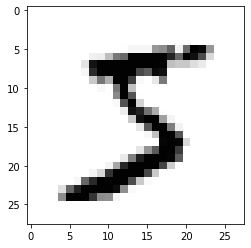

In [4]:
print(Y_train[0])
plt.imshow(X_train[0],cmap='Greys')

### Changing Dimension of input from N * 28 * 28 to N * 784

In [5]:
28*28

784

In [6]:
X_train.shape[0]

50000

In [7]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_train.shape

(50000, 784)

In [8]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
X_test.shape

(10000, 784)

In [9]:
Y_train = LabelBinarizer().fit_transform(Y_train)
Y_test = LabelBinarizer().fit_transform(Y_test)
Y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [10]:
print(Y_train.shape)
print(Y_test.shape)

(50000, 10)
(10000, 10)


In [11]:
num_classes = Y_train.shape[1]
num_feat = X_train.shape[1]
num_out = Y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
start_learning_rate = 0.001
regularizer_rate = 0.1

In [12]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Placeholder

In [13]:
input_X = tf.placeholder('float32',shape=(None,num_feat),name='input_X')
input_Y = tf.placeholder('float32',shape=(None,num_classes),name='input_Y')
keep_prob = tf.placeholder(tf.float32)

# Initialization

In [14]:
w0 = tf.Variable(tf.random_normal([num_feat, num_layers_0],stddev=1/tf.sqrt(float(num_feat))))
b0 = tf.Variable(tf.random_normal([num_layers_0]))
w1 = tf.Variable(tf.random_normal([num_layers_0, num_layers_1],stddev=1/tf.sqrt(float(num_layers_0))))
b1 = tf.Variable(tf.random_normal([num_layers_1]))
w2 = tf.Variable(tf.random_normal([num_layers_1, num_out],stddev=1/tf.sqrt(float(num_layers_1))))
b2 = tf.Variable(tf.random_normal([num_out]))

# Activation Function

In [15]:
hidden_output_0 = tf.nn.relu(tf.matmul(input_X,w0)+b0)
hidden_output_0_0 = tf.nn.dropout(hidden_output_0,keep_prob)
hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0_0,w1)+b1)
hidden_output_1_1 = tf.nn.dropout(hidden_output_1,keep_prob)
predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_1,w2)+b2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Loss Function

In [16]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predicted_y,labels=input_Y))+regularizer_rate*(tf.reduce_mean(tf.square(b0)))*(tf.reduce_mean(tf.square(b1)))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Backtrack using optimizer

In [17]:
learning_rate = tf.train.exponential_decay(start_learning_rate,0,5,0.85,staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[w0,w1,w2,b0,b1,b2])

In [18]:
correct_pred = tf.equal(tf.argmax(Y_train,1),tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [19]:
batch_size = 128
epochs = 125
dropout_prob = 0.6

In [20]:
training_accuracy = []
training_loss = []
testing_accuracy = []

In [21]:
s = tf.InteractiveSession()

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
print(training_loss,training_accuracy,testing_accuracy)

[] [] []


In [ ]:
s.run(tf.global_variables_initializer())
for epoch in range(epochs):
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer,{input_X:X_train[arr[index:index+batch_size]],input_Y:Y_train[arr[index:index+batch_size]],keep_prob:dropout_prob})
        training_accuracy.append(s.run(accuracy,feed_dict={input_X:X_train,input_Y:Y_train,keep_prob:1}))
        testing_accuracy.append(accuracy_score(Y_test.argmax(1),s.run(predicted_y,{input_X:X_test,keep_prob:1}).argmax(1)))
        training_loss.append(s.run(loss,{input_X:X_train,input_Y:Y_train,keep_prob:1}))
    print("Epochs:{0}, Train loss:{1:.2f},Train accu:{2:.3f},Test accu:{3:3f}".format(epoch,training_loss[epoch],training_accuracy[epoch],testing_accuracy[epoch]))

Epochs:0, Train loss:2.40,Train accu:0.128,Test accu:0.130300
Epochs:1, Train loss:2.38,Train accu:0.103,Test accu:0.101900
Epochs:2, Train loss:2.36,Train accu:0.112,Test accu:0.111900
Epochs:3, Train loss:2.34,Train accu:0.163,Test accu:0.165700
Epochs:4, Train loss:2.31,Train accu:0.278,Test accu:0.274400
Epochs:5, Train loss:2.29,Train accu:0.345,Test accu:0.346300
Epochs:6, Train loss:2.27,Train accu:0.334,Test accu:0.336000
Epochs:7, Train loss:2.23,Train accu:0.363,Test accu:0.371700
Epochs:8, Train loss:2.20,Train accu:0.432,Test accu:0.441900
Epochs:9, Train loss:2.18,Train accu:0.524,Test accu:0.532100
Epochs:10, Train loss:2.15,Train accu:0.581,Test accu:0.581900
Epochs:11, Train loss:2.13,Train accu:0.597,Test accu:0.599100
Epochs:12, Train loss:2.11,Train accu:0.601,Test accu:0.603000
Epochs:13, Train loss:2.09,Train accu:0.611,Test accu:0.614800
Epochs:14, Train loss:2.06,Train accu:0.639,Test accu:0.643700
Epochs:15, Train loss:2.04,Train accu:0.685,Test accu:0.693800
Ep